<a href="https://colab.research.google.com/github/hyunwookim129/pneumonia_detection/blob/main/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:35<00:00, 68.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path

In [3]:
train_image_path =pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
val_image_path = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')
test_image_path = pathlib.Path('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')
images_class = os.listdir(train_image_path)
print(images_class)

['NORMAL', 'PNEUMONIA']


In [4]:
normal_images = os.listdir(train_image_path / "NORMAL")
pneumonia_images = os.listdir(train_image_path / "PNEUMONIA")
num_normal_images = len(normal_images)
num_pneumonia_images = len(pneumonia_images)

print(f"Number of normal images: {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_images}")



Number of normal images: 1341
Number of PNEUMONIA images: 3875


Number of normal images: 1341

Number of Pneumonia images: 3875

imbalance between normal and Pneumonia image may cause bias

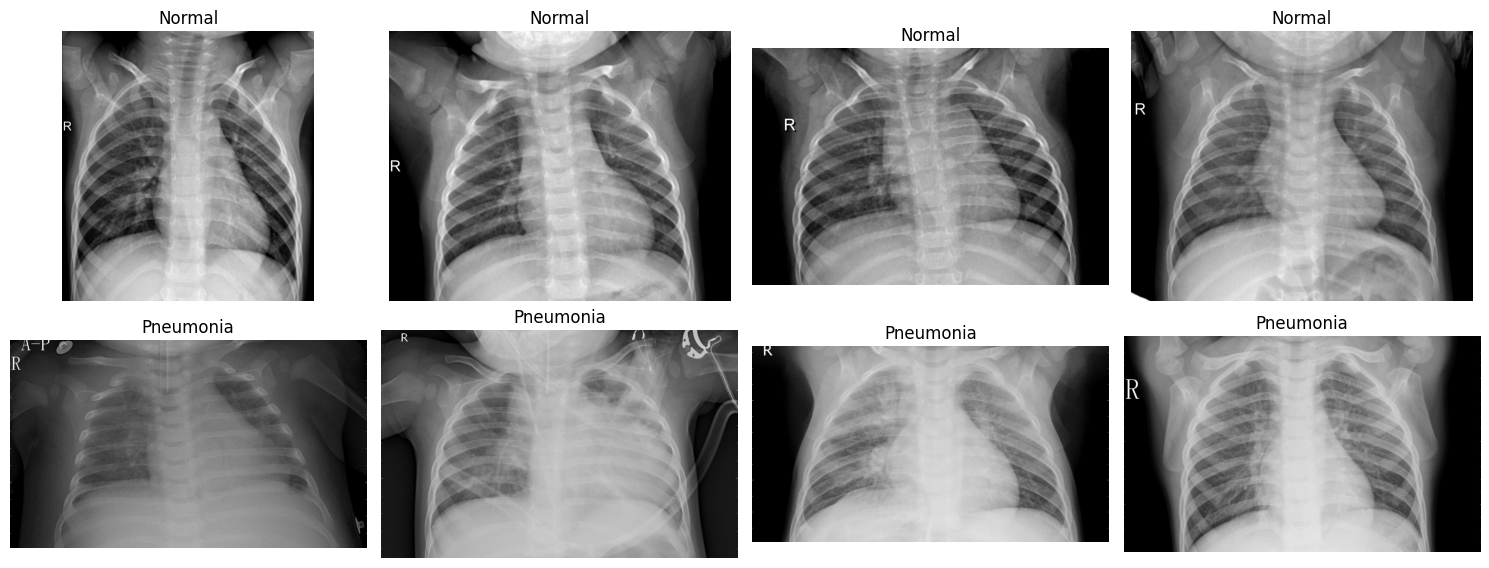

In [5]:
sample_normal_images = normal_images[:4]
sample_pneumonia_images = pneumonia_images[:4]


fig, axes = plt.subplots(2, 4, figsize=(15, 6))
for i, img_name in enumerate(sample_normal_images):
    img_path = train_image_path / "NORMAL" / img_name
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    ax = axes[0, i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Normal")
    ax.axis('off')  # Eksenleri kaldır


for i, img_name in enumerate(sample_pneumonia_images):
    img_path = train_image_path / "PNEUMONIA" / img_name
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)

    ax = axes[1, i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pneumonia")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
gpu_devices = tf.config.list_physical_devices('GPU')


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the data
train_generator = train_datagen.flow_from_directory(
    train_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_image_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model (TensorFlow will automatically use the GPU)
with tf.device('/GPU:0'):  # Explicitly use GPU
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        callbacks=[early_stopping]
    )

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 455ms/step - accuracy: 0.7401 - loss: 0.6008 - val_accuracy: 0.7500 - val_loss: 0.5686
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 399ms/step - accuracy: 0.8308 - loss: 0.3695 - val_accuracy: 0.8125 - val_loss: 0.4135
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 406ms/step - accuracy: 0.8596 - loss: 0.3028 - val_accuracy: 0.6875 - val_loss: 0.7600
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.8696 - loss: 0.2947 - val_accuracy: 0.8125 - val_loss: 0.4928
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 398ms/step - accuracy: 0.8779 - loss: 0.2702 - val_accuracy: 0.8125 - val_loss: 0.4540
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 397ms/step - accuracy: 0.8853 - loss: 0.2687 - val_accuracy: 0.8750 - val_loss: 0.4083
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 397ms/step - accuracy: 0.9015 - loss: 0.2446 - val_accuracy: 0.7500 - val_loss: 0.8098
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - accuracy: 0.9006 - loss: 0.2451 - val

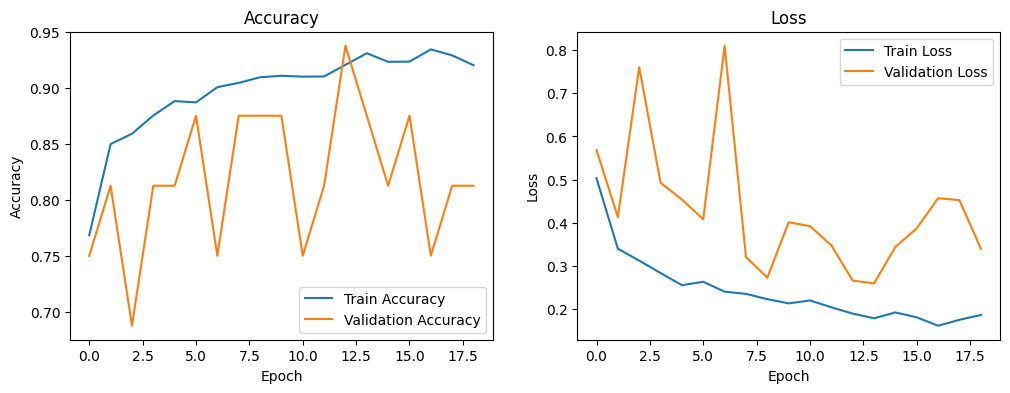

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array


def predict_pneumonia(image_path):
    img = cv2.imread(str(image_path))
    img = cv2.resize(img, (150, 150))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    with tf.device('/GPU:0'):  # Use GPU for prediction
        prediction = model.predict(img)[0][0]
    if prediction > 0.5:
        print("Prediction: Pneumonia")
    else:
        print("Prediction: Normal")

# Test prediction
predict_pneumonia(test_image_path/ "NORMAL" / "IM-0001-0001.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
Prediction: Normal


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.90      0.81      0.85       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624

Overall Test Accuracy: 0.89
AUC-ROC: 0.96
AUC-PR: 0.97
Confusion Matrix:


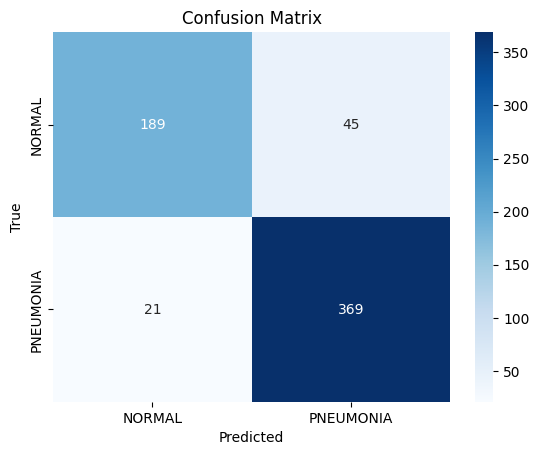

Sensitivity (Recall for PNEUMONIA): 0.95
Specificity (Recall for NORMAL): 0.81


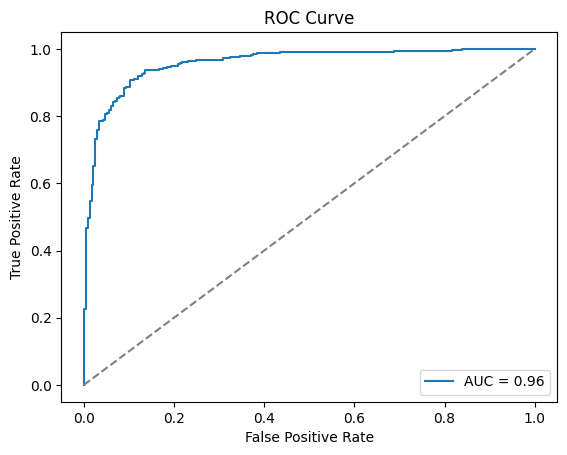

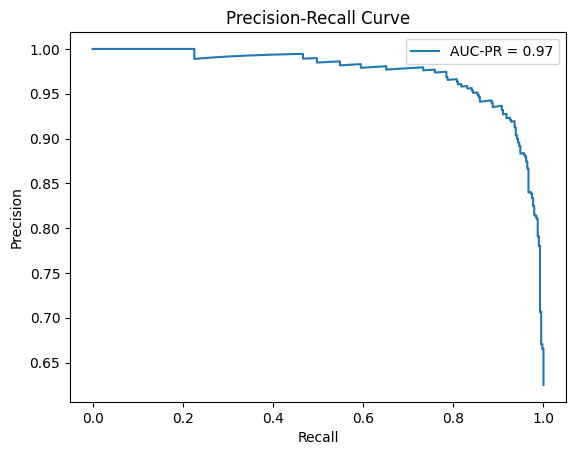

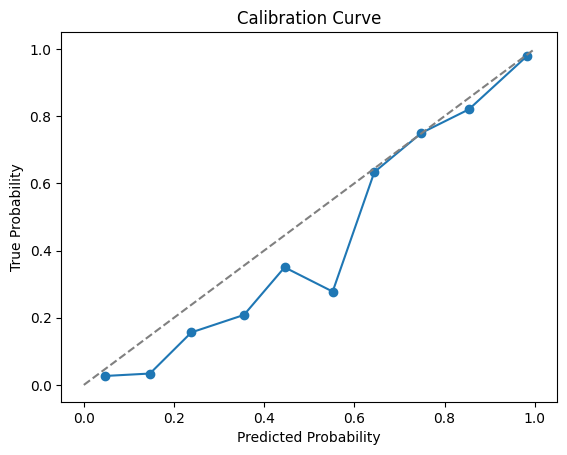

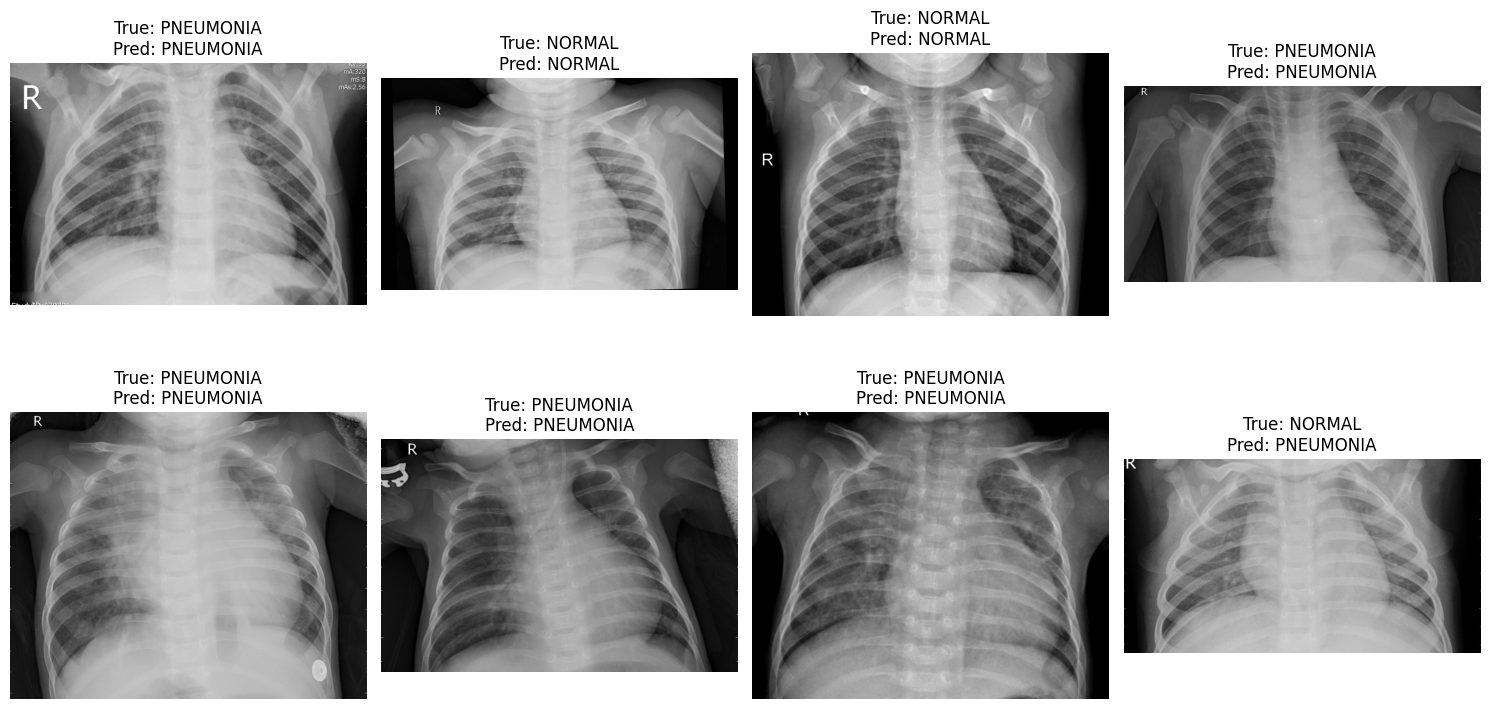

In [14]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc,roc_curve
from sklearn.calibration import calibration_curve
import seaborn as sns

# Enhanced function
def test_and_visualize_with_metrics(model, test_generator):
    # Get predictions and true labels
    predictions = model.predict(test_generator)
    y_true = test_generator.classes  # True labels
    y_pred = (predictions > 0.5).astype(int)  # Predicted labels

    # Class labels
    class_indices = test_generator.class_indices
    class_names = list(class_indices.keys())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Overall accuracy
    from sklearn.metrics import accuracy_score
    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Test Accuracy: {overall_accuracy:.2f}")

    # AUC-ROC
    auc_roc = roc_auc_score(y_true, predictions)
    print(f"AUC-ROC: {auc_roc:.2f}")

    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_true, predictions)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR: {auc_pr:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Sensitivity and Specificity
    TP = cm[1, 1]  # True Positives
    FN = cm[1, 0]  # False Negatives
    FP = cm[0, 1]  # False Positives
    TN = cm[0, 0]  # True Negatives

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    print(f"Sensitivity (Recall for PNEUMONIA): {sensitivity:.2f}")
    print(f"Specificity (Recall for NORMAL): {specificity:.2f}")

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal for random guessing
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y_true, predictions, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.show()

    # Visualize random sample predictions
    visualize_results_with_generator(test_generator, predictions, class_names)

# Visualization function remains the same
def visualize_results_with_generator(test_generator, predictions, class_names):
    # Display a few images with predictions
    filepaths = test_generator.filepaths
    true_labels = test_generator.classes
    predicted_labels = (predictions > 0.5).astype(int)

    # Select a few images for visualization
    sample_indices = np.random.choice(len(filepaths), size=8, replace=False)
    sample_images = [filepaths[i] for i in sample_indices]
    sample_predictions = [predicted_labels[i] for i in sample_indices]
    sample_true_labels = [true_labels[i] for i in sample_indices]

    # Plot images with predictions
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        img = cv2.imread(sample_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_names[sample_true_labels[i]]
        pred_label = class_names[sample_predictions[i][0]]

        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the enhanced function
test_and_visualize_with_metrics(model, test_generator)
